In [3]:
import numpy as np
import pandas as pd
import xlsxwriter

import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

In [4]:
def new_submission_file(predictions, file_name):
    workbook = xlsxwriter.Workbook(file_name + 'submission.xlsx')
    worksheet = workbook.add_worksheet()
    
    row = 0
    col = 0
    
    worksheet.write(row, col, 'Index')
    worksheet.write(row, col + 1, 'Quality')
    
    row += 1
    
    prediction_list = predictions.tolist()
    
    
    for i in range(predictions.size):
        worksheet.write(row, col, i + 1)
        worksheet.write(row, col + 1, prediction_list[i])
        row += 1
    
    workbook.close()

In [5]:
data = pd.read_csv("WineDescription.csv")
display(data.head(n=10))

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
5,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
6,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6
7,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
8,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
9,8.1,0.22,0.43,1.5,0.044,28.0,129.0,0.9938,3.22,0.45,11.0,6


In [6]:
raw_features = data.drop('quality', axis = 1)
labels = data['quality']

In [7]:
print ("Correlations between features in dataset:")
df = pd.DataFrame(raw_features, columns = raw_features.columns.tolist())
print (df.corr(method = "kendall"))
print('\n')

Correlations between features in dataset:
                      fixed acidity  volatile acidity  citric acid  \
fixed acidity              1.000000         -0.029043     0.209737   
volatile acidity          -0.029043          1.000000    -0.101664   
citric acid                0.209737         -0.101664     1.000000   
residual sugar             0.085291          0.080065     0.023025   
chlorides                  0.070007          0.001675     0.007962   
free sulfur dioxide       -0.006503         -0.057138     0.065784   
total sulfur dioxide       0.086552          0.084780     0.051918   
density                    0.196045          0.016507     0.060284   
pH                        -0.287519         -0.042427    -0.116878   
sulphates                 -0.010779         -0.012497     0.040891   
alcohol                   -0.074522          0.010857    -0.013525   

                      residual sugar  chlorides  free sulfur dioxide  \
fixed acidity               0.085291   0.0700

In [8]:
min_max_scaler = MinMaxScaler()
#features = min_max_scaler.fit_transform(raw_features)

In [18]:
features = preprocessing.scale(raw_features)

(4398,)
(4398, 1)
(4398,)
(4398, 1)
(4398,)
(4398, 1)
(4398,)
(4398, 1)
(4398,)
(4398, 1)
(4398,)
(4398, 1)
(4398,)
(4398, 1)
(4398,)
(4398, 1)
(4398,)
(4398, 1)
(4398,)
(4398, 1)
(4398,)
(4398, 1)


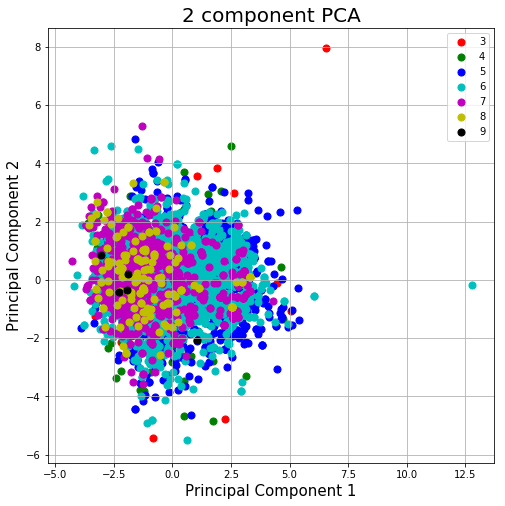

In [10]:
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(features)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['Principal component 1', 'Principal component 2'])

finalDf = pd.concat([principalDf, data[['quality']]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = np.unique(labels.values)
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['quality'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'Principal component 1']
               , finalDf.loc[indicesToKeep, 'Principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [11]:
def random_forest_param_selection(X, y):
    
    rfc = RandomForestClassifier(random_state=42)
    
    param_grid = {
        'n_estimators': [2625, 2650, 2675],
        'max_depth' :  [28,29,30, 27, 26],
    }
    
    folds = KFold(n_splits = 3, random_state = 42)
    scorer = make_scorer(mean_squared_error, greater_is_better=False)
    clf = GridSearchCV(rfc, param_grid, cv = folds, scoring = scorer)
    cross_score = cross_val_score(estimator = clf, X = X, y = y, cv = folds)
    meanScore = np.average(cross_score)
    print("Training Score: ", meanScore)
    
    clf.fit(X, y)
    print('Best score: {}'.format(clf.best_score_))
    print('Best parameters: {}'.format(clf.best_params_))
    
    return clf.best_params_

In [14]:
def ada_param_selection(X, y, clf):
    
    abc = AdaBoostClassifier(base_estimator = clf)
    
    param_grid = {
        'n_estimators': [20, 25, 30],
        'learning_rate' :  [0.5, 0.1, 0.05],
    }
    
    folds = KFold(n_splits = 3, random_state = 42)
    scorer = make_scorer(mean_squared_error, greater_is_better=False)
    clf = GridSearchCV(abc, param_grid, cv = folds, scoring = scorer)
    cross_score = cross_val_score(estimator = clf, X = X, y = y, cv = folds)
    meanScore = np.average(cross_score)
    print("Training Score: ", meanScore)
    
    clf.fit(X, y)
    print('Best score: {}'.format(clf.best_score_))
    print('Best parameters: {}'.format(clf.best_params_))
    
    return clf.best_params_


In [15]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size = 0.75, test_size = 0.25, random_state = 42)

print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

#n_estimators = 3500, max_depth = 40, random_state=42
'''
dictionary = random_forest_param_selection(X_train, y_train)
n_estimators = dictionary['n_estimators']
max_depth = dictionary['max_depth']
clf1 = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth)'''

'''
Training set has 3298 samples.
Testing set has 1100 samples.
Training Score:  -0.49333719359197065
Best score: -0.49332929047907825
Best parameters: {'max_depth': 30, 'n_estimators': 2600}
RandomForestClassifier Error: 0.4354545454545454
RandomForestClassifier Score: 0.6781818181818182

Training set has 3298 samples.
Testing set has 1100 samples.
Training Score:  -0.4972771389968842
Best score: -0.49302607640994545
Best parameters: {'max_depth': 28, 'n_estimators': 2650}
RandomForestClassifier Error: 0.4381818181818182
RandomForestClassifier Score: 0.6754545454545454

Training set has 3298 samples.
Testing set has 1100 samples.
Training Score:  -0.4933374693247304
Best score: -0.49302607640994545
Best parameters: {'max_depth': 28, 'n_estimators': 2650}
RandomForestClassifier Error: 0.4309090909090909
RandomForestClassifier Score: 0.68

Training set has 3298 samples.
Testing set has 1100 samples.
Training Score:  -0.49424600876830177
Best score: -0.49181322013341416
Best parameters: {'learning_rate': 0.05, 'n_estimators': 20}
AdaBoostClassifier Error: 0.43363636363636365
AdaBoostClassifier Score: 0.6772727272727272
'''
clf1 = RandomForestClassifier(n_estimators = 2650, max_depth = 28, random_state=42)
dictionary = ada_param_selection(X_train, y_train, clf1)
abc = AdaBoostClassifier(n_estimators = dictionary['n_estimators'], base_estimator = clf1, learning_rate=dictionary['learning_rate'])
abc.fit(X_train,y_train)
y_predict = abc.predict(X_test)
error = mean_squared_error(y_test, y_predict)
score = accuracy_score(y_test, y_predict)
print ("RandomForestClassifier Error:",error)
print ("RandomForestClassifier Score:",score)

Training set has 3298 samples.
Testing set has 1100 samples.
Training Score:  -0.49424600876830177
Best score: -0.49181322013341416
Best parameters: {'learning_rate': 0.05, 'n_estimators': 20}
RandomForestClassifier Error: 0.43363636363636365
RandomForestClassifier Score: 0.6772727272727272
